In [2]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Machine Learning

##  Convolutional Neural Network (CNN)

This tutorial demonstrates training a simple [Convolutional Neural Network](https://developers.google.com/machine-learning/glossary/#convolutional_neural_network) (CNN) to classify Flowers dataset.

In [3]:
### Import Libraries

import os

# import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay


import tensorflow as tf


%matplotlib inline

In [4]:
physical_devices = tf.config.list_physical_devices('GPU') 

if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [5]:
physical_devices

[]

In [6]:
# Some basic parameters

inpDir = os.path.join('./') # location where input data is stored
outDir = './' # location to store outputs
subDir = 'flower_photos' # location of the images
modelDir = './'
valDir = 'valid_flowers'
altName = 'dropout_bn_no_bias_swish_flowers'


RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production

tf.random.set_seed(RANDOM_STATE)

EPOCHS = 100   # number of cycles to run

ALPHA = 0.01

BATCH_SIZE = 16

TEST_SIZE = 0.2

IMG_HEIGHT = 188

IMG_WIDTH = 188

FLIP_MODE = "horizontal_and_vertical"

# for rotation transformation 
ROTATION_FACTOR = (-0.1, 0.1) 
FILL_MODE = 'nearest'

ES_PATIENCE = 20 # if performance does not improve stop

LR_PATIENCE = 10 # if performace is not improving reduce alpha

LR_FACTOR = 0.5 # rate of reduction of alpha


# Set parameters for decoration of plots
params = {'legend.fontsize' : 'large',
          'figure.figsize'  : (15,6),
          'axes.labelsize'  : 'x-large',
          'axes.titlesize'  :'x-large',
          'xtick.labelsize' :'large',
          'ytick.labelsize' :'large',
         }

CMAP = plt.cm.brg

plt.rcParams.update(params) # update rcParams

## Helper Function

In [7]:
def fn_plot_hist(hist_df):
    
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)

    ax = axes[0]

    hist_df.plot(y = [hist_df.columns[0],hist_df.columns[2]], ax = ax, colormap=CMAP)

    lossmin = hist_df[hist_df.columns[0]].min()

    testmin = hist_df[hist_df.columns[2]].min()

    # little beautification
    txtstr = "Min {}: \n Training : {:7.4f}\n Testing   : {:7.4f}".format(hist_df.columns[0],
                                                                          lossmin,
                                                                          testmin) #text to plot

    # place a text box in upper left in axes coords

    ax.text(0.4, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

    ax.set_xlabel("Epochs")

    ax.set_ylabel(hist_df.columns[0].capitalize())

    ax.grid();

    ax = axes[1]

    hist_df.plot( y = [hist_df.columns[1], hist_df.columns[3]], ax = ax, colormap=CMAP)

    # little beautification
    accmin = hist_df[hist_df.columns[1]].max()
    testmin = hist_df[hist_df.columns[3]].max()
    txtstr = "Max {}: \n Training : {:7.4f}\n Testing   : {:7.4f}".format(hist_df.columns[1],
                                                                                accmin,
                                                                                testmin) #text to plot

    # place a text box in upper left in axes coords

    ax.text(0.4, 0.5, txtstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

    ax.set_xlabel("Epochs")
    ax.set_ylabel(hist_df.columns[1].capitalize())
    ax.grid();
    plt.tight_layout()

In [8]:
def fn_plot_label(tr_ds, ts_ds):
    
    plt.figure(figsize = (15,5))
    
    plt.subplot(1,2,1)

    train_labels = tf.concat([y for x, y in tr_ds], axis = 0).numpy()
    
    unique, _, counts = tf.unique_with_counts(train_labels)
    
    plt.bar(range(len(unique)), counts, align='center',color = 'DarkBlue', alpha = 0.7)
    
    plt.title('Training Set')
    
    plt.xticks(range(len(unique)), class_names);
    plt.grid()


    plt.subplot(1,2,2)

    val_labels = tf.concat([y for x, y in ts_ds], axis = 0).numpy()
    
    unique, _, counts = tf.unique_with_counts(val_labels)
    
    plt.bar(range(len(unique)), counts, align='center', color = 'Orange', alpha = 0.7)
    
    plt.title('Test Set')
    
    plt.xticks(range(len(unique)), class_names)
    
    plt.grid()
    
    plt.show()

## Load Dataset

Images are under flower_photos

     |- daisy
     |- dandelion
     |- roses
     |- sunflowers
     |- tulips

In [9]:
data_dir = os.path.join(inpDir, subDir)

In [10]:
import pathlib
#dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
#data_dir = tf.keras.utils.get_file(origin=dataset_url,
#                                   fname='flower_photos',
#                                   untar=True)
data_dir = pathlib.Path(data_dir)

In [11]:
# load data and split in training and validation from a sub dir

# training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=TEST_SIZE,
    subset="training",
    seed=RANDOM_STATE,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=TEST_SIZE,
    subset="validation",
    seed=RANDOM_STATE,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


### Is it picking the class names?

In [12]:
class_names = train_ds.class_names
print('total ', len(class_names), class_names)

total  5 ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


### Verify the data

To verify that the dataset looks correct, let's plot the first batch from the training set and display the class name below each image.


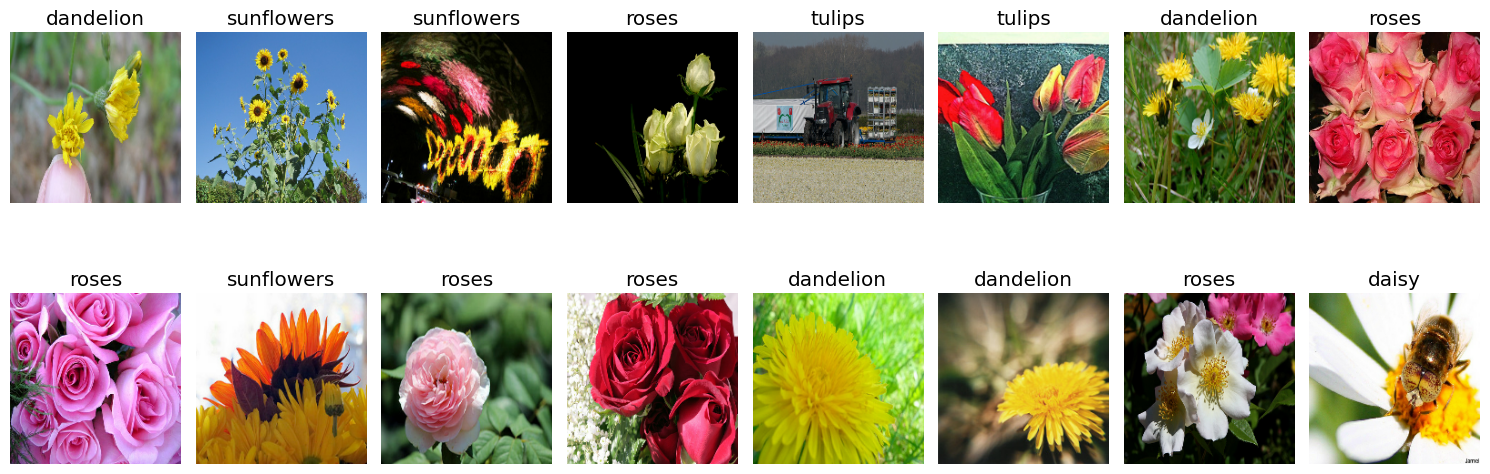

In [13]:
for images, labels in train_ds.take(1): # gets a batch of first BATCH_SIZE images
    
    for i in range(BATCH_SIZE):
        
        plt.subplot(int(BATCH_SIZE/8),8,i+1)
        
        plt.grid(False)
        
        plt.imshow(images[i].numpy().astype("uint8")) # image_size has converted these images to float
        
        plt.title(class_names[labels[i]])
        
        plt.axis("off")
    
    plt.tight_layout()
    
    plt.show()

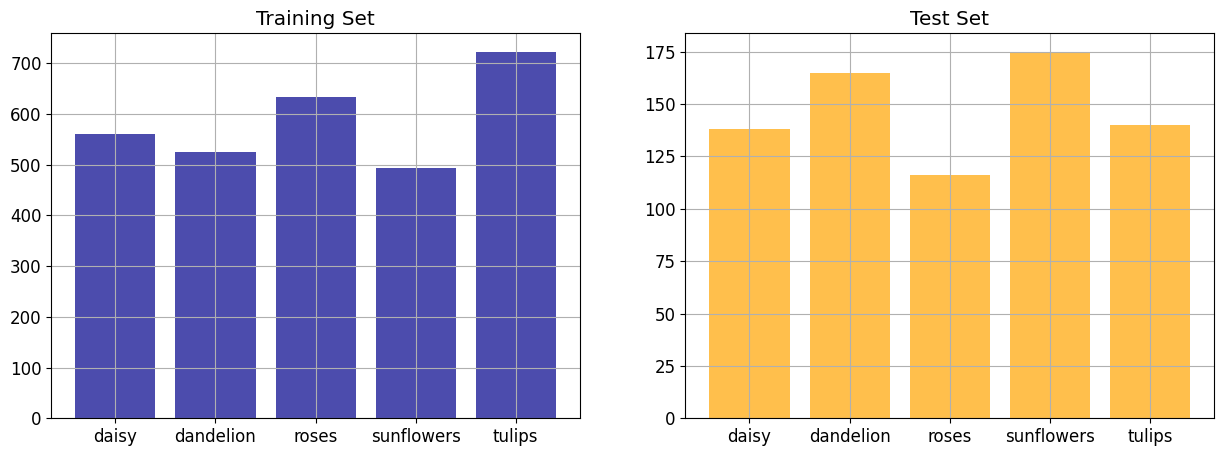

In [14]:
fn_plot_label(train_ds, test_ds)

### Input shape

If we plan to use input layer, we need input shape. In MNIST_FASHION, we executed the model and let framework capture input shape from the data

In [15]:
images[i].shape

TensorShape([188, 188, 3])

In [16]:
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)

## RandomZoom

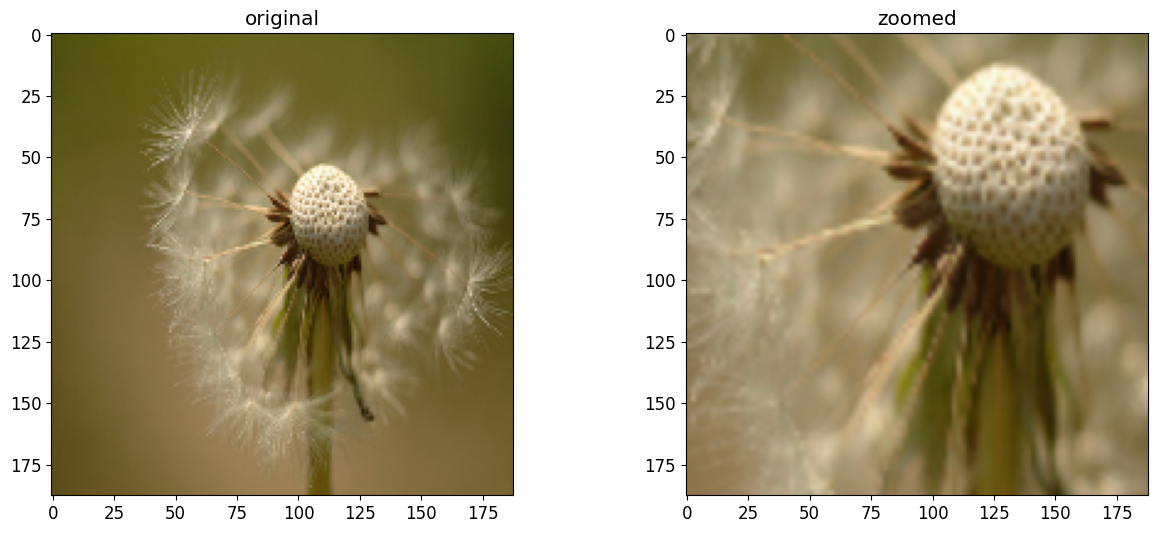

In [17]:
layer = tf.keras.layers.RandomZoom(height_factor=(-0.5,-0.5),
                                   width_factor=(-0.5,-0.5)
                                  )

plt.figure()

img_num = 3

for images, labels in train_ds.take(1):
    
    out_images = layer(images)
    
    plt.subplot(1,2,1)
    
    plt.title('original')
    
    plt.imshow(images[img_num].numpy().astype('uint8'))
    
    plt.subplot(1,2,2)
    
    plt.title('zoomed')
    
    plt.imshow(out_images[img_num].numpy().astype('uint8'))

### Random Rotation

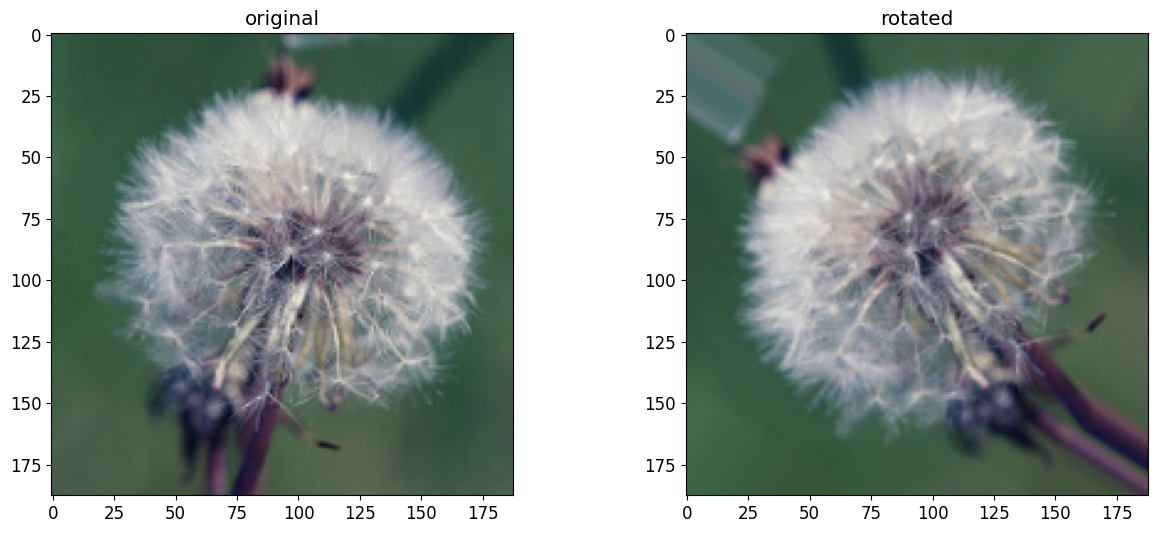

In [18]:
layer =   tf.keras.layers.RandomRotation((-1., 1.), fill_mode='nearest')

plt.figure()

img_num = 3

for images, labels in train_ds.take(1):
    
    out_images = layer(images)
    
    plt.subplot(1,2,1)
    
    plt.title('original')
    
    plt.imshow(images[img_num].numpy().astype('uint8'))
    
    plt.subplot(1,2,2)
    
    plt.title('rotated')
    
    plt.imshow(out_images[img_num].numpy().astype('uint8'))

### Standardize the data

The original RGB channel values are in the [0, 255] range. `Resizing` has converted those values into **floats**. Standardize values to be in the [0, 1] range by using the `tf.keras.layers.experimental.preprocessing.Rescaling` layer.

In [19]:
## Optimize for performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [20]:
def build_model(input_shape, n_classes):

    dor1 = 0.15
    dor2 = 0.25
    dor3 = 0.4

    krnl_init = tf.keras.initializers.GlorotUniform(
                                   seed=RANDOM_STATE
                                   )
    
    model = tf.keras.Sequential([
        
        # Scaling all images between 0 and 1
        tf.keras.layers.Rescaling(1./255),

        # Data Augumentation : ---------------
        tf.keras.layers.RandomFlip(mode=FLIP_MODE, seed=RANDOM_STATE ),
        

        tf.keras.layers.RandomRotation(ROTATION_FACTOR, fill_mode = FILL_MODE, seed=RANDOM_STATE ),
        
        #tf.keras.layers.RandomTranslation(height_factor = (0.2,0.3), 
        #                                  width_factor= (0.2,0.3) ),
        #tf.keras.layers.RandomZoom(height_factor=(-0.3, -0.2),
        #                           width_factor=(-0.3, -0.2)),
                                 

        # Set 1 : ---------------
        tf.keras.layers.Conv2D(filters = 64,
                               kernel_initializer = krnl_init,
                               kernel_size = (3, 3),
                               padding = 'same', #  output_shape = 188, 188, 64
                               use_bias = False,
                               input_shape = input_shape ),
        
        tf.keras.layers.BatchNormalization(), #  output_shape = 188, 188, 64

        tf.keras.layers.Activation('swish'),
        
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)), #  output_shape = 94, 94, 64

        tf.keras.layers.Dropout(dor1), #  output_shape = 94, 94, 64
        
        # Set 2 : ---------------
        tf.keras.layers.Conv2D(filters = 128,
                               kernel_initializer = krnl_init,
                               kernel_size = (3,3),
                               use_bias = False), #  output_shape = 92, 92, 128
        
        tf.keras.layers.BatchNormalization(), #  output_shape = 92, 92, 128

        tf.keras.layers.Activation('swish'),

        tf.keras.layers.MaxPooling2D(pool_size=(2,2)), #  output_shape = 46, 46, 128

        tf.keras.layers.Dropout(dor2), #  output_shape = 46, 46, 128

        # Set 3 : ---------------
        tf.keras.layers.Conv2D(filters =256,
                               kernel_initializer = krnl_init,
                               kernel_size = (3,3),
                               use_bias = False), #  output_shape = 44, 44, 256
                                 
        tf.keras.layers.BatchNormalization(), #  output_shape = 44, 44, 256

        tf.keras.layers.Activation('swish'),

        tf.keras.layers.MaxPooling2D(pool_size=(2,2)), #  output_shape = 22, 22, 256

        tf.keras.layers.Dropout(dor2), #  output_shape = 22, 22, 256

        # Set 4: ---------------
        tf.keras.layers.Conv2D(filters = 512,
                               kernel_initializer= krnl_init,
                               kernel_size = (3,3),
                               use_bias = False), #  output_shape = 20, 20, 512
        
        tf.keras.layers.BatchNormalization(), #  output_shape = 20, 20, 512

        tf.keras.layers.Activation('swish'),

        tf.keras.layers.MaxPooling2D(pool_size=(2,2)), #  output_shape = 10, 10, 512

        tf.keras.layers.Dropout(dor1), #  output_shape = 10, 10, 512

        # Set 5: ---------------
        tf.keras.layers.Conv2D(filters = 1024,
                               kernel_initializer= krnl_init,
                               kernel_size = (3,3),
                               use_bias = False), # output_shape = 8, 8, 1024
        
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.Activation('swish'),

        tf.keras.layers.MaxPooling2D(pool_size=(2,2)), # output_shape = 4, 4, 1024

        tf.keras.layers.Dropout(dor1), # output_shape = 4, 4, 1024

        
        # Flatten the layers
        tf.keras.layers.Flatten(),
        
        # First Dense set
        tf.keras.layers.Dense(1024,
                              kernel_initializer = krnl_init,
                              use_bias = False),
        
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.Activation('swish'),   
       
        tf.keras.layers.Dropout(dor3),
        
        # output layer
        tf.keras.layers.Dense(n_classes,
                              kernel_initializer = krnl_init
                              )

    ])
    return model

In [21]:
num_classes = len(class_names)

model = build_model(input_shape, num_classes)

In [22]:
# Directory where the checkpoints will be saved
checkpoint_dir = os.path.join(modelDir, subDir)

# Early Stopping
early_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  restore_best_weights=True,
                                                  patience=ES_PATIENCE,
                                                  verbose=1)


# Reduction schedule for alpha
lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                 factor=LR_FACTOR,
                                                 patience=LR_PATIENCE)


checkpoint_prefix = os.path.join(checkpoint_dir, altName)

# Save weights
model_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix,
                                                    monitor='val_loss',
                                                    mode='auto',
                                                    save_weights_only=True,
                                                    save_best_only=True,
                                                    verbose=1)

In [23]:
alpha = ALPHA

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=alpha),
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [24]:
history = model.fit(train_ds,
                    validation_data=test_ds,
                    callbacks=[ early_callback, model_callback, lr_reduce],
                    epochs=EPOCHS)

Epoch 1/100


184/184 [==============================] - ETA: 0s - loss: 1.8652 - accuracy: 0.3845
Epoch 1: val_loss improved from inf to 1.94563, saving model to ./flower_photos\dropout_bn_no_bias_swish_flowers
184/184 [==============================] - 471s 3s/step - loss: 1.8652 - accuracy: 0.3845 - val_loss: 1.9456 - val_accuracy: 0.2943 - lr: 0.0100
Epoch 2/100
184/184 [==============================] - ETA: 0s - loss: 1.7117 - accuracy: 0.4656
Epoch 2: val_loss did not improve from 1.94563
184/184 [==============================] - 433s 2s/step - loss: 1.7117 - accuracy: 0.4656 - val_loss: 2.1265 - val_accuracy: 0.4414 - lr: 0.0100
Epoch 3/100
154/184 [========================>.....] - ETA: 1:15 - loss: 1.5070 - accuracy: 0.5199

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 188, 188, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 188, 188, 3)       0         
                                                                 
 random_rotation_1 (RandomRo  (None, 188, 188, 3)      0         
 tation)                                                         
                                                                 
 conv2d (Conv2D)             (None, 188, 188, 64)      1728      
                                                                 
 batch_normalization (BatchN  (None, 188, 188, 64)     256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 188, 188, 64)      0

In [ ]:
res_df = pd.DataFrame(history.history)
res_df

,loss,accuracy,val_loss,val_accuracy,lr
0,1.871596,0.395436,5.079417,0.310627,0.010
1,1.710432,0.479905,1.519068,0.482289,0.010
2,1.457326,0.537807,1.707707,0.423706,0.010
3,1.282628,0.581063,1.132330,0.589918,0.010
4,1.109781,0.614441,1.408923,0.486376,0.010
5,1.084726,0.621253,1.145789,0.629428,0.010
6,1.002223,0.643392,0.957843,0.653951,0.010
7,0.932414,0.661785,0.929231,0.673025,0.010
8,0.890092,0.683242,1.003746,0.637602,0.010
9,0.835170,0.685967,1.023392,0.626703,0.010


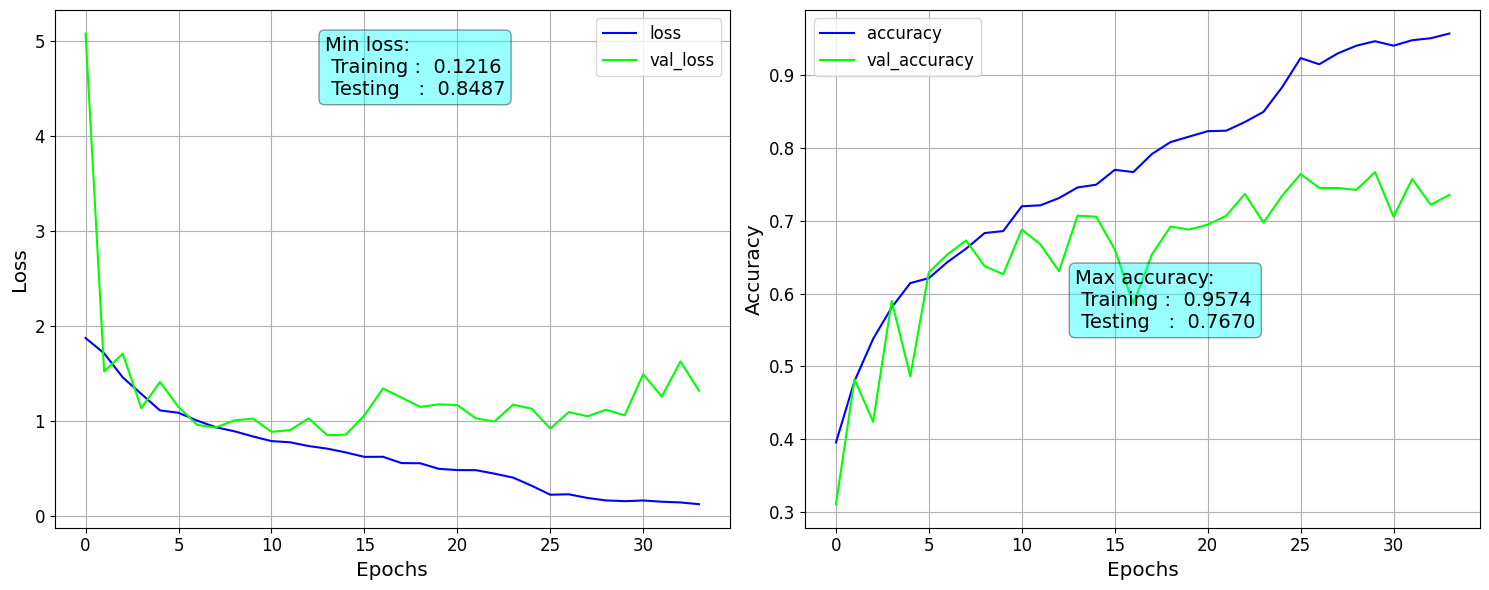

In [ ]:
fn_plot_hist(res_df)

In [ ]:
tf.train.latest_checkpoint( os.path.join(modelDir, subDir) ) 

'../models/flower_photos/dropout_bn_no_bias_swish_flowers'

In [ ]:
model1 = build_model(input_shape, num_classes)

model1.load_weights(tf.train.latest_checkpoint( os.path.join(modelDir, subDir) ) )

In [ ]:
model1.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Evaluate the model

In [ ]:
test_loss, test_acc = model1.evaluate(test_ds, verbose=1)

46/46 [==============================] - 1s 24ms/step - loss: 0.8487 - accuracy: 0.7071


In [ ]:
#yhat = model.predict(X_test, batch_size=n_batch)
yhat = model1.predict(test_ds)

46/46 [==============================] - 1s 23ms/step


In [ ]:
y_test = tf.concat([y for x, y in test_ds], axis=0)

In [ ]:
y_pred = yhat.argmax(axis = 1)

print('Accuracy score on Test Data : {:.3f}%'.format( accuracy_score(y_test, y_pred)*100))

Accuracy score on Test Data : 70.708%


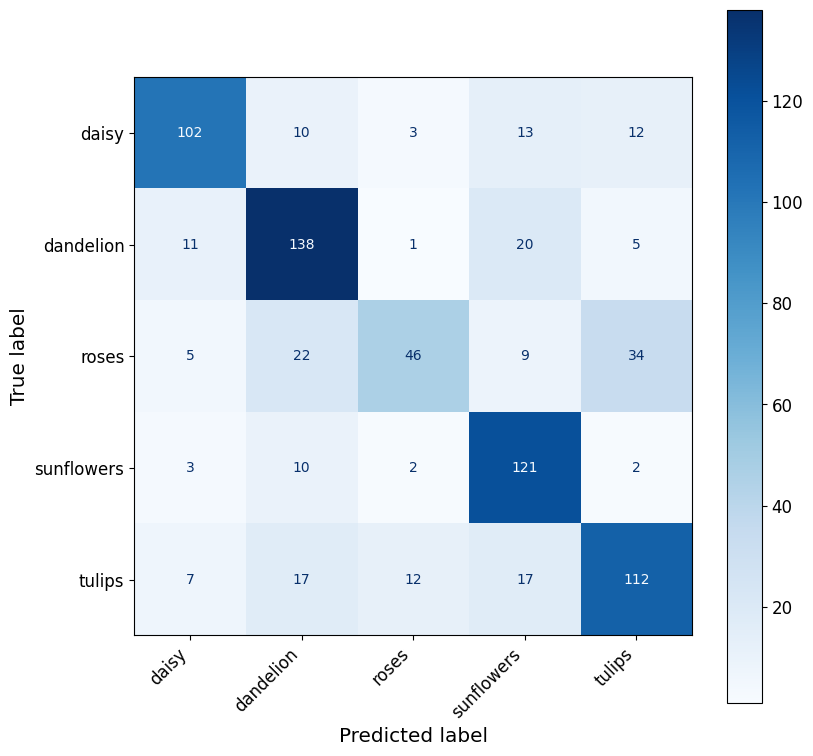

In [ ]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                       display_labels=class_names)

fig, ax = plt.subplots(figsize = (9,9))
disp.plot(ax = ax, cmap=plt.cm.Blues);
ax.set_xticklabels(class_names,rotation=45, ha='right');

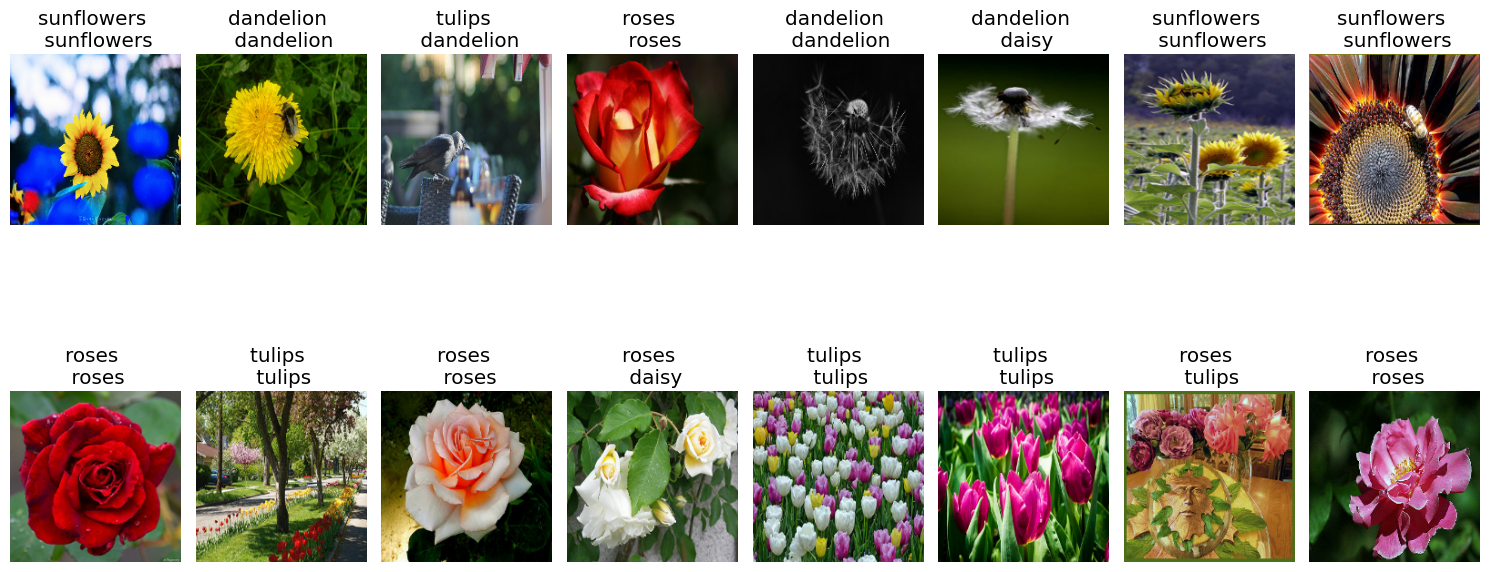

In [ ]:
plt.figure(figsize=(15,8))
for images, labels in test_ds.take( 1 ):
    
    for i in range ( BATCH_SIZE ):
        
        plt.subplot(int( BATCH_SIZE / 8 ),8, i+1 )
        
        plt.grid(False)
        
        plt.imshow ( images[i].numpy().astype( "uint8" ) )
        
        plt.title('{} \n {}'.format( class_names[labels.numpy()[i]], class_names[y_pred[i]]))
        
        plt.axis("off")
        
    plt.tight_layout()
    
    plt.show()

In [ ]:
model_path = checkpoint_prefix+'.h5'
model.save(model_path, save_format='h5')

In [ ]:
new_model = tf.keras.models.load_model(model_path)

In [ ]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 188, 188, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 188, 188, 3)       0         
                                                                 
 random_rotation_1 (RandomRo  (None, 188, 188, 3)      0         
 tation)                                                         
                                                                 
 conv2d (Conv2D)             (None, 188, 188, 64)      1728      
                                                                 
 batch_normalization (BatchN  (None, 188, 188, 64)     256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 188, 188, 64)      0

In [ ]:































































































































































































































test_loss, test_acc = new_model.evaluate(test_ds, verbose=1)

46/46 [==============================] - 1s 24ms/step - loss: 0.8487 - accuracy: 0.7071
